### Test of data instantiation

In [2]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
from torchmetrics import FBetaScore, Accuracy
from torchvision.utils import draw_bounding_boxes

import torchvision.transforms as T
from torchvision.transforms import functional as F

import pandas as pd
from src import BWDatasets
from paddleocr import PaddleOCR

import paddle
print(paddle.device.is_compiled_with_cuda()) 

True


### Ensure Reproducibility

In [3]:
seed = 115
generator = torch.Generator()
generator.manual_seed(seed)
np_generator = np.random.default_rng(seed=seed)

In [4]:
label_path = "dataset/datasets/rf/ringcodes.csv"
image_path = "dataset/datasets/rf/images"
bb_path = "dataset/datasets/rf/labels"
max_n = 10
transform = T.Compose([
    # T.Resize((64,32)),
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])
exp_dataset = BWDatasets.TrainDataSet(img_path=image_path, labels_path=label_path, bb_path=bb_path, transform=transform, max_n=max_n)


In [5]:
def bb_txt_to_list(bb_path):
    
    with open(bb_path) as f:
        line = f.readline().strip()

        bb = line.split(' ')
    
    return bb

In [6]:
def calculate_bb_cords(image, bb):

    img_w = image.shape[2]
    img_h = image.shape[1]

    # Calculate x and y coordinates of the bb
    bb_x = img_w * float(bb[1])
    bb_y = img_h * float(bb[2])

    # Calculate height and width of the bb, and divide by 2
    bb_w = (image.shape[2] * float(bb[3])) / 2
    bb_h = (image.shape[1] * float(bb[4])) / 2

    # Calculate corners of bb
    min_x = max(0, bb_x - (bb_w))
    max_x = min(img_w, bb_x + (bb_w))
    min_y = max(0, bb_y - (bb_h))
    max_y = min(img_h, bb_y + (bb_h))

    return min_x, min_y, max_x, max_y


In [7]:
def draw_image_with_bb(img, bb_cords):

    # img = T.ToTensor()(img)

    # Pre process image
    # img_uint8 = (img * 255).to(dtype=torch.uint8)

    # Prepare bounding boxes
    boxes = torch.tensor([[bb_cords[0], bb_cords[1], bb_cords[2], bb_cords[3]]], dtype=torch.int)

    img_boxes = draw_bounding_boxes(
        img,
        boxes,
        colors="red",
        width=2
    )
    img_boxes = img_boxes.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_boxes)
    plt.axis("off")
    plt.show()

Checking image at state: before grey
Is image None: False
Shape: (440, 256, 3), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: after grey
Is image None: False
Shape: (440, 256), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
(905.179968, 472.12739999999997, 969.9457920000001, 582.09516)


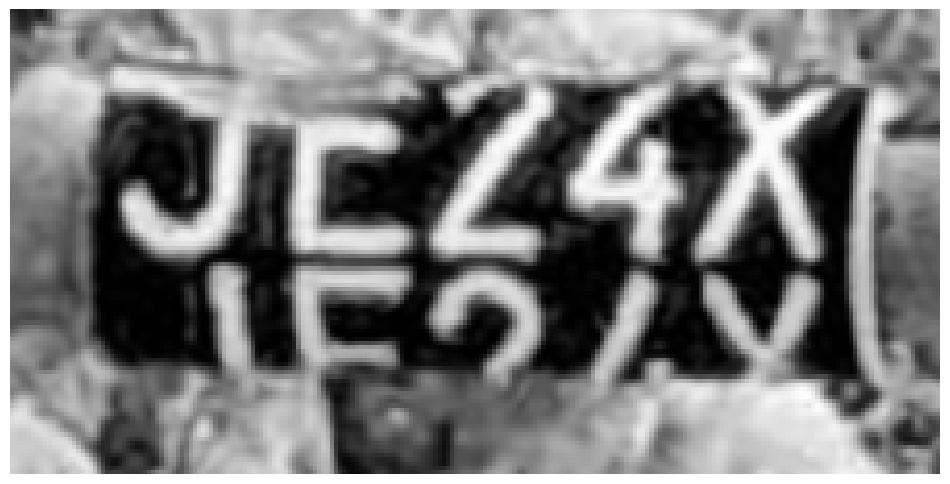

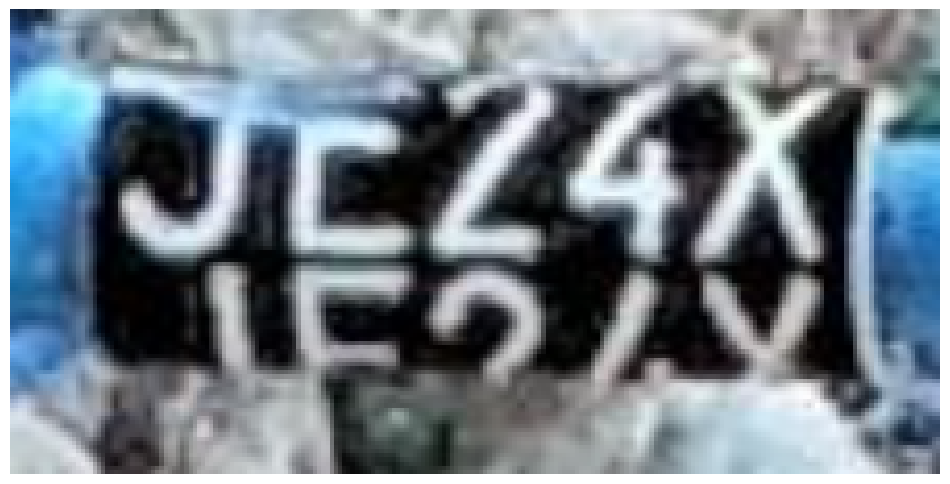

In [8]:
data = exp_dataset[7]
print(data["bb"])

draw_image_with_bb(data["ocr_image"], data["bb"])
draw_image_with_bb(data["image"], data["bb"])

In [9]:
#stop




In [10]:

ocr = PaddleOCR(lang="en", 
        #    text_detection_model_dir="src/models/paddleOCR/det", 
        #    text_recognition_model_dir="src/models/paddleOCR/rec", 
        #    textline_orientation_model_dir="src/models/paddleOCR/cls", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True, device='gpu')

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5689.76it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 3562.04it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5043.25it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [

In [11]:
def draw_image(img):
    img_uint8 = (img * 255).to(dtype=torch.uint8)
    img_uint8 = img_uint8.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

In [12]:

def crop_image_with_bb(image, bb):
    x = int(bb[0])
    y = int(bb[1])
    width = int(bb[2]) - int(bb[0])
    height = int(bb[3]) - int(bb[1])

    img_crop = F.crop(image, top=y, left=x, height=height, width=width)
    return img_crop


In [13]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True, generator=generator)


In [14]:
def prediction(dataloader):
    preds = []
    targets = []
    for data in dataloader:
        images = BWDatasets.tensor_to_numpy(data["ocr_image"])
        labels = data["label"][0]
        print(images.shape)
        for i, image in enumerate(images):

            print(image.shape)

            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [15]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labesl: {labels}')
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [16]:
preds, labels = prediction(exp_loader)


Checking image at state: before grey
Is image None: False
Shape: (524, 352, 3), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: after grey
Is image None: False
Shape: (524, 352), Pixel Datatype: uint8
Min Value: 0, Max Value: 252
------------
Checking image at state: before grey
Is image None: False
Shape: (416, 280, 3), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: after grey
Is image None: False
Shape: (416, 280), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: before grey
Is image None: False
Shape: (544, 388, 3), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: after grey
Is image None: False
Shape: (544, 388), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Checking image at state: before grey
Is image None: False
Shape: (444, 292, 3), Pixel Datatype: uint8
Min Value: 0, Max Value: 255
------------
Chec

ValueError: axes don't match array

In [ ]:
evaluate_model(preds=preds, labels=labels)


preds: ['JJ94C', '18艺5', 'A8085', 'JE25X', 'Not Found', 'Not Found', '', 'Not Found', 'JE49C', 'Not Found']
labesl: ['JJ94C', 'JE24X', 'J808V', 'JE25X', 'J194V', 'JJ89C', 'JE24X', 'JJ94C', 'JE94C', 'JE24X']
Model F1 Score: 0.5555555820465088
Model Accuracy: 0.20000000298023224
